In [1]:
from auto_mm_bench.datasets import dataset_registry
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, Dataset

print(dataset_registry.list_keys()) 

/home/james/CodingProjects/TextNTabularExplanations/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['product_sentiment_machine_hack', 'jigsaw_unintended_bias', 'jigsaw_unintended_bias100K', 'google_qa_label', 'google_qa_answer_helpful', 'google_qa_answer_plausible', 'google_qa_answer_type_procedure', 'google_qa_answer_type_reason_explanation', 'google_qa_question_type_reason_explanation', 'google_qa_answer_satisfaction', 'women_clothing_review', 'melbourne_airbnb', 'mercari_price_suggestion', 'ae_price_prediction', 'mercari_price_suggestion100K', 'imdb_genre_prediction', 'fake_job_postings', 'kick_starter_funding', 'jc_penney_products', 'wine_reviews', 'news_popularity', 'news_channel', 'news_popularity2', 'fake_job_postings2', 'bookprice_prediction', 'data_scientist_salary', 'california_house_price']


In [19]:
dataset_name = 'news_popularity2'

train_dataset = dataset_registry.create(dataset_name, 'train')
test_dataset = dataset_registry.create(dataset_name, 'test')
print(train_dataset.data.head())

label_cols = train_dataset.label_columns
tab_cols = [' n_tokens_content', ' average_token_length', ' num_keywords']
text_cols = ['article_title']

X_train = train_dataset.data[tab_cols]
y_train = train_dataset.data[label_cols]
X_test = test_dataset.data[tab_cols]
y_test = test_dataset.data[label_cols]

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: ',r2_score(y_test, y_pred))

# Text only
# join text columns and label columns
train_txt = train_dataset.data[text_cols + label_cols]


    n_tokens_content   average_token_length   num_keywords  log_shares  \
0              402.0               4.159204            7.0    7.550135   
1              184.0               4.266304           10.0    7.901377   
2              809.0               4.248455            8.0    8.594339   
3             1046.0               4.540153            8.0    7.244942   
4              300.0               4.603333            6.0    7.378384   

                                       article_title  
0  Any.DO Moment Pushes You to Actually Tackle Yo...  
1                 iPad Activations on AT&T Jump 200%  
2  This Simple Action Will Dramatically Grow Your...  
3  Twitter CEO Finally Gets a Verified Account on...  
4         Slingbox Can Now Stream TV on Roku Players  


ValueError: Unknown label type: 'continuous'

In [62]:
train_txt = train_dataset.data[text_cols + label_cols] 
test_txt = test_dataset.data[text_cols + label_cols]

# load dataset from dataframe
train_ds = Dataset.from_pandas(train_txt)
test_ds = Dataset.from_pandas(test_txt)
train_ds = train_ds.train_test_split(test_size=0.15)
ds = DatasetDict({'train': train_ds['train'], 'validation': train_ds['test'], 'test': test_ds})
ds = ds.map(lambda x: {'label': x[label_cols[0]], 'text': x[text_cols[0]]})

model_base = 'distilbert-base-uncased'

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
        model_base, num_labels=1, problem_type="regression"
    )
tokenizer = AutoTokenizer.from_pretrained(model_base)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

ds = ds.map(tokenize_function, batched=True)

# Training arguments
training_args = TrainingArguments(
    output_dir='test',
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    torch_compile=True, # Needs to be true if PyTorch 2.0
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[2023-03-09 10:33:38,846] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03-09 10:33:38,852] torch._inductor.utils: [WARNING] not enough cuda cores to use max_autotune mode
[2023-03-09 10:33:47,837] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
 33%|███▎      | 318/957 [05:31<10:19,  1.03it/s][2023-03-09 10:39:08,136] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03-09 10:39:15,690] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
 33%|███▎      | 319/957 [05:46<57:28,  5.41s/it]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: article_title, log_shares, text. If article_title, log_shares, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num

{'eval_loss': 1.038662314414978, 'eval_runtime': 26.9347, 'eval_samples_per_second': 133.731, 'eval_steps_per_second': 2.116, 'epoch': 1.0}


Model weights saved in test/checkpoint-319/pytorch_model.bin
 52%|█████▏    | 500/957 [09:13<07:31,  1.01it/s]  

{'loss': 2.1633, 'learning_rate': 2.387669801462905e-05, 'epoch': 1.57}


 67%|██████▋   | 638/957 [11:28<04:50,  1.10it/s]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: article_title, log_shares, text. If article_title, log_shares, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3602
  Batch size = 64
                                                 
 67%|██████▋   | 638/957 [11:46<04:50,  1.10it/s]Saving model checkpoint to test/checkpoint-638
Configuration saved in test/checkpoint-638/config.json


{'eval_loss': 0.9967308640480042, 'eval_runtime': 18.7888, 'eval_samples_per_second': 191.71, 'eval_steps_per_second': 3.034, 'epoch': 2.0}


Model weights saved in test/checkpoint-638/pytorch_model.bin
100%|██████████| 957/957 [16:52<00:00,  1.18it/s]The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: article_title, log_shares, text. If article_title, log_shares, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3602
  Batch size = 64
                                                 
100%|██████████| 957/957 [17:10<00:00,  1.18it/s]Saving model checkpoint to test/checkpoint-957
Configuration saved in test/checkpoint-957/config.json


{'eval_loss': 0.9790486693382263, 'eval_runtime': 18.6451, 'eval_samples_per_second': 193.188, 'eval_steps_per_second': 3.057, 'epoch': 3.0}


Model weights saved in test/checkpoint-957/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from test/checkpoint-957 (score: 0.9790486693382263).
100%|██████████| 957/957 [17:11<00:00,  1.08s/it]

{'train_runtime': 1031.5752, 'train_samples_per_second': 59.341, 'train_steps_per_second': 0.928, 'train_loss': 1.545490197128886, 'epoch': 3.0}


TrainOutput(global_step=957, training_loss=1.545490197128886, metrics={'train_runtime': 1031.5752, 'train_samples_per_second': 59.341, 'train_steps_per_second': 0.928, 'train_loss': 1.545490197128886, 'epoch': 3.0})

In [68]:
# Load best model and predict
preds = trainer.evaluate(ds['test'])

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: article_title, log_shares, text. If article_title, log_shares, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6002
  Batch size = 64
425it [05:36,  3.46it/s]

BackendCompilerFailed: debug_wrapper raised BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

Set torch._dynamo.config.verbose=True for more information


You can suppress this exception and fall back to eager by setting:
    torch._dynamo.config.suppress_errors = True


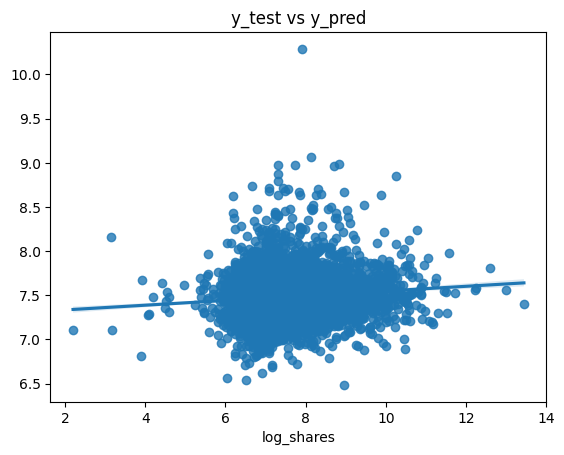

In [ ]:
# plot y_test vs y_pred
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=y_test, y=y_pred)
plt.title('y_test vs y_pred')
plt.show()



In [10]:
dataset_name = 'melbourne_airbnb'

train_dataset = dataset_registry.create(dataset_name, 'train')
test_dataset = dataset_registry.create(dataset_name, 'test')
train_dataset.data
# price_label is the target variable

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,host_verifications_manual_offline,host_verifications_offline_government_id,host_verifications_selfie,host_verifications_reviews,host_verifications_identity_manual,host_verifications_sesame_offline,host_verifications_weibo,host_verifications_email,host_verifications_sent_id,host_verifications_phone
0,25586695,https://www.airbnb.com/rooms/25586695,2.018120e+13,12/7/2018,"Beach side, art deco flat in heart of St Kilda",A beautiful art deco flat right in the heart o...,5 minutes walk to the beach. 1 minute walk to...,A beautiful art deco flat right in the heart o...,None,None,...,False,False,False,True,False,False,False,True,False,True
1,1057401,https://www.airbnb.com/rooms/1057401,2.018120e+13,12/7/2018,Modern Bayside Studio Apartment,Self contained modern apartment with its own e...,We offer a self-contained modern apartment wit...,Self contained modern apartment with its own e...,The apartment is in a quiet residential neighb...,None,...,False,True,True,True,True,False,False,True,False,True
2,24949385,https://www.airbnb.com/rooms/24949385,2.018120e+13,12/7/2018,Spacious Saint kilda home with a View,Short term Flatshare in the heart of St Kilda....,None,Short term Flatshare in the heart of St Kilda....,None,None,...,False,False,False,True,False,False,False,True,False,True
3,20075093,https://www.airbnb.com/rooms/20075093,2.018120e+13,12/7/2018,Rewarding Richmond Location-Outstanding Apartm...,Welcome to my amazing apartment located in the...,It will be a pleasure to host you in my fantas...,Welcome to my amazing apartment located in the...,Richmond is one of the most vibrant and divers...,"Please remove your shoes whilst inside, as the...",...,False,True,False,True,False,False,False,True,False,False
4,16275657,https://www.airbnb.com/rooms/16275657,2.018120e+13,12/7/2018,Close to the centre of Melbourne.,Beautiful 3 bedroomed double story townhouse s...,Two living areas - use of both. 2 bedrooms. B...,Beautiful 3 bedroomed double story townhouse s...,Double story townhouse. Host has own space ups...,None,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,15386981,https://www.airbnb.com/rooms/15386981,2.018120e+13,12/7/2018,Sunny and Relaxed Balaclava Apartment,5 min walk to Carlisle St with lots of great c...,"My home is open plan, light filled, clean & ti...",5 min walk to Carlisle St with lots of great c...,Eateries: (all within walking distance) Attica...,Definitely not a party house. No drinking or s...,...,False,False,False,True,False,False,False,True,False,True
18312,9824540,https://www.airbnb.com/rooms/9824540,2.018120e+13,12/7/2018,New Apartment Close to Everything,"100m Front train station Awesome cafes, bars e...","All essentials included, enough space for a co...","100m Front train station Awesome cafes, bars e...",Flatmate is very easy going and barely home! l...,None,...,False,False,False,False,False,False,False,True,False,True
18313,20635094,https://www.airbnb.com/rooms/20635094,2.018120e+13,12/7/2018,Victoria House,My home is located on the ground floor of a sm...,None,My home is located on the ground floor of a sm...,Square & Compass cafe is immediately next door...,"Although there is no on site car parking, ther...",...,False,True,True,True,True,False,False,True,False,True
18314,20378109,https://www.airbnb.com/rooms/20378109,2.018120e+13,12/7/2018,Across Airport Transfer - 1 Bedroom,An exclusive and modern apartment with 5 stars...,Finely furnished and consists of a queen bed. ...,An exclusive and modern apartment with 5 stars...,None,None,...,False,True,True,True,True,False,False,True,False,True


In [10]:
dataset_name = 'imdb_genre_prediction'

train_dataset = dataset_registry.create(dataset_name, 'train')
test_dataset = dataset_registry.create(dataset_name, 'test')
train_dataset.data

label_cols = train_dataset.label_columns
tab_cols = ['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank']
text_cols = ['Description']

train_dataset.data[tab_cols] = train_dataset.data[tab_cols].fillna(train_dataset.data[tab_cols].mean())
test_dataset.data[tab_cols] = test_dataset.data[tab_cols].fillna(test_dataset.data[tab_cols].mean())

X_train = train_dataset.data[tab_cols]
y_train = train_dataset.data[label_cols]
X_test = test_dataset.data[tab_cols]
y_test = test_dataset.data[label_cols]

model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
# print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
# print('R^2: ',r2_score(y_test, y_pred))
# acc
print('Accuracy: ', np.mean(y_test.values.flatten() == y_pred))

/home/james/CodingProjects/TextNTabularExplanations/env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/james/CodingProjects/TextNTabularExplanations/env/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy:  0.75


In [32]:
# Make Genre_is_Drama from a bool to a binary variable
train_dataset.data

,Rank,Title,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Genre_is_Drama
0,161,Mine,"After a failed assassination attempt, a soldie...",Fabio Guaglione,"Armie Hammer, Annabelle Wallis,Tom Cullen, Cli...",2016,106,6.0,5926,82.877094,40.0,0
1,171,Nightcrawler,"When Louis Bloom, a con man desperate for work...",Dan Gilroy,"Jake Gyllenhaal, Rene Russo, Bill Paxton, Riz ...",2014,118,7.9,332476,32.280000,76.0,1
2,425,London Has Fallen,"In London for the Prime Minister's funeral, Mi...",Babak Najafi,"Gerard Butler, Aaron Eckhart, Morgan Freeman,A...",2016,99,5.9,100702,62.400000,28.0,1
3,466,Sherlock Holmes: A Game of Shadows,Sherlock Holmes and his sidekick Dr. Watson jo...,Guy Ritchie,"Robert Downey Jr., Jude Law, Jared Harris, Rac...",2011,129,7.5,357436,186.830000,48.0,0
4,415,Mechanic: Resurrection,Arthur Bishop thought he had put his murderous...,Dennis Gansel,"Jason Statham, Jessica Alba, Tommy Lee Jones,M...",2016,98,5.6,48161,21.200000,38.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
795,872,Dragonball Evolution,The young warrior Son Goku sets out on a quest...,James Wong,"Justin Chatwin, James Marsters, Yun-Fat Chow, ...",2009,85,2.7,59512,9.350000,45.0,0
796,934,Detour,A young law student blindly enters into a pact...,Christopher Smith,"Tye Sheridan, Emory Cohen, Bel Powley,Stephen ...",2016,97,6.3,2205,82.877094,46.0,0
797,977,Dark Places,Libby Day was only eight years old when her fa...,Gilles Paquet-Brenner,"Charlize Theron, Nicholas Hoult, Christina Hen...",2015,113,6.2,31634,82.877094,39.0,1
798,825,Man Down,"In a post-apocalyptic America, former U.S. Mar...",Dito Montiel,"Shia LaBeouf, Jai Courtney, Gary Oldman, Kate ...",2015,90,5.8,4779,82.877094,27.0,1


In [28]:
train_txt = train_dataset.data
test_txt = test_dataset.data
train_dataset.data['Genre_is_Drama'] = train_dataset.data['Genre_is_Drama'].astype(int)
test_dataset.data['Genre_is_Drama'] = test_dataset.data['Genre_is_Drama'].astype(int)

# load dataset from dataframe
train_ds = Dataset.from_pandas(train_txt)
test_ds = Dataset.from_pandas(test_txt)
train_ds = train_ds.train_test_split(test_size=0.15, seed=42)
ds = DatasetDict({'train': train_ds['train'], 'validation': train_ds['test'], 'test': test_ds})
ds.push_to_hub('imdb_genre_prediction')

Pushing split train to the Hub.
Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
Pushing split validation to the Hub.
Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
Pushing split test to the Hub.
Deleting unused files from dataset repository: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


In [15]:

ds = ds.map(lambda x: {"Genre_is_Drama": int(x["Genre_is_Drama"])})

In [25]:
def bool_to_int(x):
    return float(x)

ds = ds.map(lambda x: {"Genre_is_Drama": bool_to_int(x["Genre_is_Drama"])})

In [27]:
ds['train'][0]

{'Rank': 645,
 'Title': 'Viral',
 'Description': "Following the outbreak of a virus that wipes out the majority of the human population, a young woman documents her family's new life in quarantine and tries to protect her infected sister.",
 'Director': 'Henry Joost',
 'Actors': "Sofia Black-D'Elia, Analeigh Tipton,Travis Tope, Michael Kelly",
 'Year': 2016,
 'Runtime (Minutes)': 85,
 'Rating': 5.5,
 'Votes': 3564,
 'Revenue (Millions)': 82.87709352517986,
 'Metascore': 72.0,
 'Genre_is_Drama': True}

In [41]:
y_test.values.shape

(200, 1)

In [43]:
np.expand_dims(y_pred, axis=1).shape

(200, 1)

In [17]:
train_dataset.data[tab_cols] = train_dataset.data[tab_cols].fillna(train_dataset.data[tab_cols].mean())
train_dataset.data.isnull().sum()

Rank                  0
Title                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime (Minutes)     0
Rating                0
Votes                 0
Revenue (Millions)    0
Metascore             0
Genre_is_Drama        0
dtype: int64

In [12]:
dataset_name = 'fake_job_postings2'

train_dataset = dataset_registry.create(dataset_name, 'train')
test_dataset = dataset_registry.create(dataset_name, 'test')
train_dataset.data

100%|██████████| 16.9M/16.9M [00:01<00:00, 10.5MiB/s]


100%|██████████| 16.9M/16.9M [00:01<00:00, 11.3MiB/s]


100%|██████████| 4.30M/4.30M [00:00<00:00, 6.25MiB/s]


,title,salary_range,description,required_experience,required_education,fraudulent
0,Senior Cognos Developer - IBM Cognos Framework...,NaN,Experienced Senior Cognos Developer is require...,NaN,NaN,0
1,Sales Reps (EMEA),NaN,Apcera is completely re-imagining application ...,NaN,NaN,0
2,Junior Product Support Engineer - Funnelback,50000-65000,Funnelback is an exciting and growing company ...,Associate,Bachelor's Degree,0
3,Legal Collections Manager,NaN,I. Position Description:The Collectio...,Associate,Bachelor's Degree,0
4,Manager of Support Services,NaN,GetCloudServices is a privately held technolog...,Mid-Senior level,Bachelor's Degree,0
...,...,...,...,...,...,...
12720,Milton Keynes Fragrance and Beauty Promotional...,NaN,We are currently recruiting for an exciting Sa...,NaN,NaN,0
12721,Information Technology Administrator,NaN,The Information Technology Administrator is hi...,Associate,Associate Degree,0
12722,Partnership Manager,45000-50000,About the Position:The Partnership Manager ens...,Associate,Bachelor's Degree,0
12723,Commercial Moving Staff,NaN,Schroeder Solutions is a full-service interior...,Entry level,High School or equivalent,0


In [14]:
dataset_name = 'california_house_price'

train_dataset = dataset_registry.create(dataset_name, 'train')
test_dataset = dataset_registry.create(dataset_name, 'test')
train_dataset.data

100%|██████████| 44.1M/44.1M [00:03<00:00, 13.2MiB/s]


100%|██████████| 11.0M/11.0M [00:01<00:00, 9.53MiB/s]


,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,5355 Monterey Rd,2.562758,Take advantage of this great opportunity of ow...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,NaN,...,NaN,2.631833,2.252658,2020-05-13,2.585435,2019-08-22,950000.0,Los Angeles,90042,CA
1,612 Mission Ridge Rd,2.660983,Mountain View Sanctuary in the Heart of Santa ...,SingleFamily,1960.0,Forced Air,"Central Air, Ceiling Fan(s)","Attached, Gar #2, Inside Entrance",2.383057,4,...,"Attached, Gar #2, Inside Entrance",2.713810,2.355307,2020-11-12,2.654483,2013-11-27,1170000.0,Santa Barbara,93103,CA
2,551 Chiquita Ave,2.670472,downtown mountain view cottage. big lot. Hardw...,SingleFamily,1947.0,"Forced air, Gas",None,"Garage, Off-street, Covered",2.295743,2,...,"Garage, Off-street, Covered",2.698402,2.346480,2020-03-03,2.663399,2007-04-20,850000.0,Mountain View,94041,CA
3,12613 Nantucket Ct,2.697672,FABULOUS FAMILY HOME LOCATED IN ONE OF SARATOG...,SingleFamily,1964.0,Central Forced Air,Central AC,"Garage, Garage - Attached, Covered",2.366527,3,...,"Garage, Garage - Attached, Covered",2.565280,2.193350,2020-08-29,2.697624,NaN,NaN,Saratoga,95070,CA
4,1979 Josephine Ave,2.635857,"Perfect to make your own, get excited about pl...",SingleFamily,1958.0,Central Forced Air,None,"Garage, Garage - Attached, Covered",2.289851,3,...,"Garage, Garage - Attached, Covered",2.492540,2.163513,2020-11-10,2.632667,NaN,NaN,San Jose,95124,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37946,824 Euclid Ave,2.691352,Video Tour. 824 Euclid is a 2 level house like...,Condo,1911.0,NaN,NaN,"Detached, Private, Tandem, On Site - Mapped (C...",NaN,4,...,"Detached, Private, Tandem, On Site - Mapped (C...",2.744005,2.411994,2020-03-06,2.696457,NaN,NaN,San Francisco,94118,CA
37947,722 Broadway,2.544603,This Home is Located In the Seabright Neighbor...,SingleFamily,1924.0,Floor Furnace,None,Carport,2.217123,More than One Bedroom on Ground Floor,...,Carport,2.436529,2.037747,2019-01-10,2.591294,2019-02-13,661000.0,Santa Cruz,95062,CA
37948,5008 Bela Dr,2.665737,Pristine home in desirable Happy Valley. Gorg...,SingleFamily,1959.0,"Forced Air, Natural Gas","Ceiling Fan(s), Central Air","Garage Door Opener, Attached, Int Access From ...",2.273768,3,...,"Garage Door Opener, Attached, Int Access From ...",2.534166,2.188590,2020-06-26,2.663477,NaN,NaN,San Jose,95129,CA
37949,1114 Niguel Ln,2.583588,This beautiful Basking Ridge condo is perfect ...,Condo,1999.0,"Fireplace, Central Forced Air",Central AC,"Garage, Garage - Attached, Covered",NaN,Walk-in Closet,...,"Garage, Garage - Attached, Covered",2.631171,2.264398,2020-08-29,2.581417,2013-05-24,352000.0,San Jose,95138,CA


In [46]:
y_pred

array([7.2666516, 7.479508 , 7.5594087, ..., 7.443543 , 7.528996 ,
       7.8675036], dtype=float32)

In [39]:
tab_cols

Index([' average_token_length', ' n_tokens_content', ' num_keywords',
       'log_shares'],
      dtype='object')